# Lab: Alphavold and Vertex AI for personalized oncology (Biologic Therapy)

## Identify proteins which promote cancer growth - https://www.kaggle.com/c/msk-redefining-cancer-treatment

We can leverage Vertex AI AutoML with an approach demonstrated here - https://github.com/ROHANNAIK/Personalized-Medicine-Redefining-Cancer-Treatment

When proteins get identified we can start to explore compounds which inhibit target those proteins to change protein function.

### Cadherin-22 is a potential factor in cancer metastasis, or spread, and showed that hindering it decreased the adhesion and invasion rate of breast and brain cancer cells by up to 90 percent.

## Lectin pathway to fight cancer - https://pubmed.ncbi.nlm.nih.gov/16183566/

Mannose Binding Lectin (MBL)  
High-level summary

Certain vegetables contain a mannose-binding lectin (MBL),  Many lectins resist digestion, survive gut passage, and bind to gastrointestinal cells and/or enter the circulation intact, maintaining full biological activity. Several lectins have been found to possess anticancer properties in vitro, in vivo, and in human case studies; they are used as therapeutic agents, preferentially binding to cancer cell membranes or their receptors, causing cytotoxicity, apoptosis, and inhibition of tumor growth.



In [1]:
from IPython.display import IFrame
IFrame(src="https://en.wikipedia.org/wiki/Lectin", width='100%', height='400px')

# Problem Statement

In this lab, we will demonstrate use of AlphaFold and Vertex AI platform to explore Lectin protein as a candidate to enhance immune system to fight cancer

# Pipeline components

AlphaFold on Vertex AI Workbench, AlphaFold Protein Structure Database, Vertex AI workbench and Vertex AI pipeline to Run docking experiments. 

In [28]:
from IPython.display import IFrame
IFrame(src="https://alphafold.ebi.ac.uk/search/text/mannose-binding%20lectin?organismScientificName=Allium%20cepa", width='100%', height='400px')

# AlphaFold On Vertex AI Workbench

[Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench) offers an end-to-end notebook-based production environment that can be preconfigured with the runtime dependencies necessary to run AlphaFold on Vertex AI. With [User-Managed Notebooks](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/introduction), you can configure a GPU accelerator to run AlphaFold using Tensorflow, without having to install and manage drivers or JupyterLab instances. This notebook allows you to easily predict the structure of a protein using a slightly simplified version of [AlphaFold v2.1.0](https://doi.org/10.1038/s41586-021-03819-2). 

## ![](https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/community-content/alphafold_on_workbench/vertexai_40.png) [Launch this Notebook in Vertex AI Workbench](https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/raw/main/community-content/alphafold_on_workbench/AlphaFold.ipynb)

**Differences to AlphaFold v2.1.0**

In comparison to AlphaFold v2.1.0, this notebook notebook uses **no templates (homologous structures)** and a selected portion of the [BFD database](https://bfd.mmseqs.com/). We have validated these changes on several thousand recent PDB structures. While accuracy will be near-identical to the full AlphaFold system on many targets, a small fraction have a large drop in accuracy due to the smaller MSA and lack of templates. For best reliability, we recommend instead using the [full open source AlphaFold](https://github.com/deepmind/alphafold/), or the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/).

**This notebook has an small drop in average accuracy for multimers compared to local AlphaFold installation, for full multimer accuracy it is highly recommended to run [AlphaFold locally](https://github.com/deepmind/alphafold#running-alphafold).** Moreover, the AlphaFold-Multimer requires searching for MSA for every unique sequence in the complex, hence it is substantially slower. If your notebook times-out due to slow multimer MSA search, we recommend running AlphaFold locally.

Please note that this notebook is provided as an early-access prototype and is not a finished product. It is provided for theoretical modelling only and caution should be exercised in its use. 

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This Colab uses the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license) which are subject to the Creative Commons Attribution 4.0 International ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode)) license. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). See the full license statement below.


**More information**

You can find more information about how AlphaFold works in the following papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)
*   [AlphaFold-Multimer paper](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1)

FAQ on how to interpret AlphaFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

## Download AlphaFold Data

In [16]:
import os
import subprocess
import sys

import alphafold.common
import tqdm.notebook
from IPython.utils import io

TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

SOURCE_URL = (
    "https://storage.googleapis.com/alphafold/alphafold_params_colab_2022-01-19.tar"
)
PARAMS_DIR = "alphafold/data/params"
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
ALPHAFOLD_COMMON_DIR = os.path.dirname(alphafold.common.__file__)

try:
    with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
        with io.capture_output() as captured:

            # Download and store stereo_chemical_props.txt
            !mkdir -p ~/content/alphafold/alphafold/common
            !mkdir -p /opt/conda/lib/python3.7/site-packages/alphafold/common/
            !wget -q -P ~/content/alphafold/alphafold/common https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
            pbar.update(18)
            !cp -f ~/content/alphafold/alphafold/common/stereo_chemical_props.txt "{ALPHAFOLD_COMMON_DIR}"

            # Download alphafold_params_colab_2021-10-27.tar
            !mkdir --parents "{PARAMS_DIR}"
            !wget -O "{PARAMS_PATH}" "{SOURCE_URL}"
            pbar.update(27)

            # Un-tar alphafold_params_colab_2021-10-27.tar
            !tar --extract --verbose --file="{PARAMS_PATH}" --directory="{PARAMS_DIR}" --preserve-permissions
            # !rm "{PARAMS_PATH}"
            pbar.update(55)

except subprocess.CalledProcessError:
    print(captured)
    raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## Configure GPU Acceleration

In [17]:
# Confirm accelerator configuration
import jax

if jax.local_devices()[0].platform == "tpu":
    raise RuntimeError(
        "TPU runtime not supported. Please configure GPU acceleration on the VM."
    )
elif jax.local_devices()[0].platform == "cpu":
    print(
        "CPU-only runtime is not recommended, because prediction execution will be slow. For better performance, consider GPU acceleration on the VM."
    )
else:
    print(f"Running with {jax.local_devices()[0].device_kind} GPU")

# Make sure all necessary environment variables are set.
import os

os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "2.0"

Running with Tesla V100-SXM2-16GB GPU


## Making a prediction

Please paste the sequence of your protein in the text box below, then run the remaining cells via _Run_ > _Run Selected Cell and All Below_. You can also run the cells individually by pressing the _Play_ button on the left.

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you allocate (see FAQ below).

To start, enter the amino acid sequence(s) to fold ⬇️

If you enter only a single sequence, the monomer model will be used. If you enter multiple sequences, the multimer model will be used.

# Explore Lectin sequence: 
https://www.uniprot.org/uniprot/C0HJM8

In [29]:
from IPython.display import IFrame
IFrame(src="https://www.rcsb.org/structure/7MTC", width='100%', height='400px')

In [6]:
# Input sequences (type: str)
# sequence_1 = "TVATILTILASTCMARNVLVNNEGLYAGQSLVVEQYTFIMQDDCNLVLYEYSTPIWASNTGVTGKNGCRAVMQADGNFVVYDVKGRAVWASNSRRGNGNYILVLQKDRNVVIYGSDIWSTGTYRKKVGGTVVMAMNGTVDGGSVVGPVTVNQNVTAVRKVAAAA"
# Seq1: https://www.rcsb.org/sequence/6XM3 - Structure of SARS-CoV-2 spike at pH 5.5, single RBD up, conformation 1
# seq2, 3: https://www.rcsb.org/sequence/6XIW - Cryo-EM structure of the sodium leak channel NALCN-FAM155A complex
sequence_1 = "QCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPGSASSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQGSGYIPEAPRDGQAYVRKDGEWVLLSTFLGRSLEVLFQGPGHHHHHHHHSAWSHPQFEKGGGSGGGGSGGSAWSHPQFEK"
sequence_2 = "MTRGAWMCRQYDDGLKIWLAAPRENEKPFIDSERAQKWRLSLASLLFFTVLLSDHLWFCAEAKLTRARDKEHQQQQRQQQQQQQQQRQRQQQQQQRRQQEPSWPALLASMGESSPAAQAHRLLSASSSPTLPPSPGDGGGGGGKGNRGKDDRGKALFLGNSAKPVWRLETCYPQGASSGQCFTVENADAVCARNWSRGAAGGDGQEVRSKHPTPLWNLSDFYLSFCNSYTLWELFSGLSSPNTLNCSLDVVLKEGGEMTTCRQCVEAYQDYDHHAQEKYEEFESVLHKYLQSEEYSVKSCPEDCKIVYKAWLCSQYFEVTQFNCRKTIPCKQYCLEVQTRCPFILPDNDEVIYGGLSSFICTGLYETFLTNDEPECCDVRREEKSNNPSKGTVEKSGSCHRTSLTVSSATRLCNSRLKLCVLVLILLHTVLTASAAQNTAGLSFGGINTLEENSTNEEGGSGGSDYKDDDDKGNSDYKDDDDK"
sequence_3 = ""
#sequence_2 = "MLKRKQSSRVEAQPVTDFGPDESLSDNADILWINKPWVHSLLRICAIISVISVCMNTPMTFEHYPPLQYVTFTLDTLLMFLYTAEMIAKMHIRGIVKGDSSYVKDRWCVFDGFMVFCLWVSLVLQVFEIADIVDQMSPWGMLRIPRPLIMIRAFRIYFRFELPRTRITNILKRSGEQIWSVSIFLLFFLLLYGILGVQMFGTFTYHCVVNDTKPGNVTWNSLAIPDTHCSPELEEGYQCPPGFKCMDLEDLGLSRQELGYSGFNEIGTSIFTVYEAASQEGWVFLMYRAIDSFPRWRSYFYFITLIFFLAWLVKNVFIAVIIETFAEIRVQFQQMWGSRSSTTSTATTQMFHEDAAGGWQLVAVDVNKPQGRAPACLQKMMRSSVFHMFILSMVTVDVIVAASNYYKGENFRRQYDEFYLAEVAFTVLFDLEALLKIWCLGFTGYISSSLHKFELLLVIGTTLHVYPDLYHSQFTYFQVLRVVRLIKISPALEDFVYKIFGPGKKLGSLVVFTASLLIVMSAISLQMFCFVEELDRFTTFPRAFMSMFQILTQEGWVDVMDQTLNAVGHMWAPVVAIYFILYHLFATLILLSLFVAVILDNLELDEDLKKLKQLKQSEANADTKEKLPLRLRIFEKFPNRPQMVKISKLPSDFTVPKIRESFMKQFIDRQQQDTCCLLRSLPTTSSSSCDHSKRSAIEDNKYIDQKLRKSVFSIRARNLLEKETAVTKILRACTRQRMLSGSFEGQPAKERSILSVQHHIRQERRSLRHGSNSQRISRGKSLETLTQDHSNTVRYRNAQREDSEIKMIQEKKEQAEMKRKVQEEELRENHPYFDKPLFIVGREHRFRNFCRVVVRARFNASKTDPVTGAVKNTKYHQLYDLLGLVTYLDWVMIIVTICSCISMMFESPFRRVMHAPTLQIAEYVFVIFMSIELNLKIMADGLFFTPTAVIRDFGGVMDIFIYLVSLIFLCWMPQNVPAESGAQLLMVLRCLRPLRIFKLVPQMRKVVRELFSGFKEIFLVSILLLTLMLVFASFGVQLFAGKLAKCNDPNIIRREDCNGIFRINVSVSKNLNLKLRPGEKKPGFWVPRVWANPRNFNFDNVGNAMLALFEVLSLKGWVEVRDVIIHRVGPIHGIYIHVFVFLGCMIGLTLFVGVVIANFNENKGTALLTVDQRRWEDLKSRLKIAQPLHLPPRPDNDGFRAKMYDITQHPFFKRTIALLVLAQSVLLSVKWDVEDPVTVPLATMSVVFTFIFVLEVTMKIIAMSPAGFWQSRRNRYDLLVTSLGVVWVVLHFALLNAYTYMMGACVIVFRFFSICGKHVTLKMLLLTVVVSMYKSFFIIVGMFLLLLCYAFAGVVLFGTVKYGENINRHANFSSAGKAITVLFRIVTGEDWNKIMHDCMVQPPFCTPDEFTYWATDCGNYAGALMYFCSFYVIIAYIMLNLLVAIIVENFSLFYSTEEDQLLSYNDLRHFQIIWNMVDDKREGVIPTFRVKFLLRLLRGRLEVDLDKDKLLFKHMCYEMERLHNGGDVTFHDVLSMLSYRSVDIRKSLQLEELLAREQLEYTIEEEVAKQTIRMWLKKCLKRIRAKQQQSCSIIHSLRESQQQELSRFLNPPSIETTQPSEDTNANSQDNSMQPETSSQQQLLSPTLSDRGGSRQDAADAGKPQRKFGQWRLPSAPKPISHSVSSVNLRFGGRTTMKSVVCKMNPMTDAASCGSEVKKWWTRQLTVESDESGDDLLDIGGGSGGWSHPQFEKGGGSGGGSGGSAWSHPQFEKGSGDYKDDDDKGNSDYKDDDDK"
sequence_4 = ""
sequence_5 = ""
sequence_6 = ""
sequence_7 = ""
sequence_8 = ""

In [7]:
pwd

'/home/jupyter/imported'

In [8]:
from alphafold.notebooks import notebook_utils

input_sequences = (
    sequence_1,
    sequence_2,
    sequence_3,
    sequence_4,
    sequence_5,
    sequence_6,
    sequence_7,
    sequence_8,
)

# If folding a complex target and all the input sequences are
# prokaryotic then set `is_prokaryotic` to `True`. Set to `False`
# otherwise or if the origin is unknown.

is_prokaryote = False  # @param {type:"boolean"}

MIN_SINGLE_SEQUENCE_LENGTH = 16
MAX_SINGLE_SEQUENCE_LENGTH = 2500
MAX_MULTIMER_LENGTH = 2500

# Validate the input.
sequences, model_type_to_use = notebook_utils.validate_input(
    input_sequences=input_sequences,
    min_length=MIN_SINGLE_SEQUENCE_LENGTH,
    max_length=MAX_SINGLE_SEQUENCE_LENGTH,
    max_multimer_length=MAX_MULTIMER_LENGTH,
)

Using the multimer model with 2 sequences.


## Search against genetic databases

Once this cell has been executed, you will see statistics about the multiple sequence alignment (MSA) that will be used by AlphaFold. In particular, you’ll see how well each residue is covered by similar  sequences in the MSA.


Getting MSA for sequence 1


  0%|          | 0/245 [elapsed: 00:00 remaining: ?]

2842 unique sequences found in uniref90 for sequence 1
21 unique sequences found in smallbfd for sequence 1
10 unique sequences found in mgnify for sequence 1

2866 unique sequences found in total for sequence 1



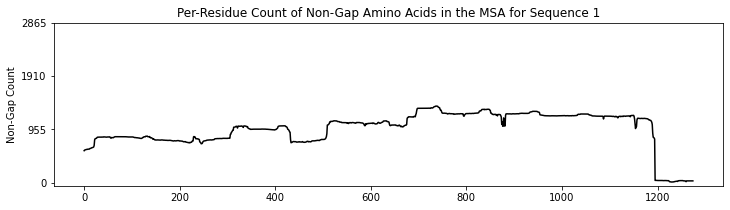


Getting MSA for sequence 2


  0%|          | 0/245 [elapsed: 00:00 remaining: ?]

884 unique sequences found in uniref90 for sequence 2
23 unique sequences found in smallbfd for sequence 2
7 unique sequences found in mgnify for sequence 2

903 unique sequences found in total for sequence 2



In [9]:
import collections
import copy
import random
from concurrent import futures
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
from alphafold.common import protein
from alphafold.data import (feature_processing, msa_pairing, pipeline,
                            pipeline_multimer)
from alphafold.data.tools import jackhmmer
from alphafold.model import config, data, model
from alphafold.relax import relax, utils
from IPython import display
from ipywidgets import GridspecLayout, Output

# Color bands for visualizing plddt
PLDDT_BANDS = [
    (0, 50, "#FF7D45"),
    (50, 70, "#FFDB13"),
    (70, 90, "#65CBF3"),
    (90, 100, "#0053D6"),
]

# --- Find the closest source ---
test_url_pattern = (
    "https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1"
)
ex = futures.ThreadPoolExecutor(3)


def fetch(source):
    request.urlretrieve(test_url_pattern.format(source))
    return source


fs = [ex.submit(fetch, source) for source in ["", "-europe", "-asia"]]
source = None
for f in futures.as_completed(fs):
    source = f.result()
    ex.shutdown()
    break

JACKHMMER_BINARY_PATH = "/usr/bin/jackhmmer"
DB_ROOT_PATH = f"https://storage.googleapis.com/alphafold-colab{source}/latest/"
# The z_value is the number of sequences in a database.
MSA_DATABASES = [
    {
        "db_name": "uniref90",
        "db_path": f"{DB_ROOT_PATH}uniref90_2021_03.fasta",
        "num_streamed_chunks": 59,
        "z_value": 135_301_051,
    },
    {
        "db_name": "smallbfd",
        "db_path": f"{DB_ROOT_PATH}bfd-first_non_consensus_sequences.fasta",
        "num_streamed_chunks": 17,
        "z_value": 65_984_053,
    },
    {
        "db_name": "mgnify",
        "db_path": f"{DB_ROOT_PATH}mgy_clusters_2019_05.fasta",
        "num_streamed_chunks": 71,
        "z_value": 304_820_129,
    },
]

# Search UniProt and construct the all_seq features only for heteromers, not homomers.
if model_type_to_use == notebook_utils.ModelType.MULTIMER and len(set(sequences)) > 1:
    MSA_DATABASES.extend(
        [
            # Swiss-Prot and TrEMBL are concatenated together as UniProt.
            {
                "db_name": "uniprot",
                "db_path": f"{DB_ROOT_PATH}uniprot_2021_03.fasta",
                "num_streamed_chunks": 98,
                "z_value": 219_174_961 + 565_254,
            },
        ]
    )

TOTAL_JACKHMMER_CHUNKS = sum(cfg["num_streamed_chunks"] for cfg in MSA_DATABASES)

MAX_HITS = {
    "uniref90": 10_000,
    "smallbfd": 5_000,
    "mgnify": 501,
    "uniprot": 50_000,
}


def get_msa(fasta_path):
    """Searches for MSA for the given sequence using chunked Jackhmmer search."""

    # Run the search against chunks of genetic databases.
    raw_msa_results = collections.defaultdict(list)
    with tqdm.notebook.tqdm(
        total=TOTAL_JACKHMMER_CHUNKS, bar_format=TQDM_BAR_FORMAT
    ) as pbar:

        def jackhmmer_chunk_callback(i):
            pbar.update(n=1)

        for db_config in MSA_DATABASES:
            db_name = db_config["db_name"]
            pbar.set_description(f"Searching {db_name}")
            jackhmmer_runner = jackhmmer.Jackhmmer(
                binary_path=JACKHMMER_BINARY_PATH,
                database_path=db_config["db_path"],
                get_tblout=True,
                num_streamed_chunks=db_config["num_streamed_chunks"],
                streaming_callback=jackhmmer_chunk_callback,
                z_value=db_config["z_value"],
            )
            # Group the results by database name.
            raw_msa_results[db_name].extend(jackhmmer_runner.query(fasta_path))

    return raw_msa_results


features_for_chain = {}
raw_msa_results_for_sequence = {}
for sequence_index, sequence in enumerate(sequences, start=1):
    print(f"\nGetting MSA for sequence {sequence_index}")

    fasta_path = f"target_{sequence_index}.fasta"
    with open(fasta_path, "wt") as f:
        f.write(f">query\n{sequence}")

    # Don't do redundant work for multiple copies of the same chain in the multimer.
    if sequence not in raw_msa_results_for_sequence:
        raw_msa_results = get_msa(fasta_path=fasta_path)
        raw_msa_results_for_sequence[sequence] = raw_msa_results
    else:
        raw_msa_results = copy.deepcopy(raw_msa_results_for_sequence[sequence])

    # Extract the MSAs from the Stockholm files.
    # NB: deduplication happens later in pipeline.make_msa_features.
    single_chain_msas = []
    uniprot_msa = None
    for db_name, db_results in raw_msa_results.items():
        merged_msa = notebook_utils.merge_chunked_msa(
            results=db_results, max_hits=MAX_HITS.get(db_name)
        )
        if merged_msa.sequences and db_name != "uniprot":
            single_chain_msas.append(merged_msa)
            msa_size = len(set(merged_msa.sequences))
            print(
                f"{msa_size} unique sequences found in {db_name} for sequence {sequence_index}"
            )
        elif merged_msa.sequences and db_name == "uniprot":
            uniprot_msa = merged_msa

    notebook_utils.show_msa_info(
        single_chain_msas=single_chain_msas, sequence_index=sequence_index
    )

    # Turn the raw data into model features.
    feature_dict = {}
    feature_dict.update(
        pipeline.make_sequence_features(
            sequence=sequence, description="query", num_res=len(sequence)
        )
    )
    feature_dict.update(pipeline.make_msa_features(msas=single_chain_msas))
    # We don't use templates in AlphaFold notebook, add only empty placeholder features.
    feature_dict.update(
        notebook_utils.empty_placeholder_template_features(
            num_templates=0, num_res=len(sequence)
        )
    )

    # Construct the all_seq features only for heteromers, not homomers.
    if (
        model_type_to_use == notebook_utils.ModelType.MULTIMER
        and len(set(sequences)) > 1
    ):
        valid_feats = msa_pairing.MSA_FEATURES + (
            "msa_uniprot_accession_identifiers",
            "msa_species_identifiers",
        )
        all_seq_features = {
            f"{k}_all_seq": v
            for k, v in pipeline.make_msa_features([uniprot_msa]).items()
            if k in valid_feats
        }
        feature_dict.update(all_seq_features)

    features_for_chain[protein.PDB_CHAIN_IDS[sequence_index - 1]] = feature_dict


# Do further feature post-processing depending on the model type.
if model_type_to_use == notebook_utils.ModelType.MONOMER:
    np_example = features_for_chain[protein.PDB_CHAIN_IDS[0]]

elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
    all_chain_features = {}
    for chain_id, chain_features in features_for_chain.items():
        all_chain_features[chain_id] = pipeline_multimer.convert_monomer_features(
            chain_features, chain_id
        )

    all_chain_features = pipeline_multimer.add_assembly_features(all_chain_features)

    np_example = feature_processing.pair_and_merge(
        all_chain_features=all_chain_features, is_prokaryote=is_prokaryote
    )

    # Pad MSA to avoid zero-sized extra_msa.
    np_example = pipeline_multimer.pad_msa(np_example, min_num_seq=512)

## Run AlphaFold

Once this cell has been executed, a zip-archive "prediction.zip" with the obtained prediction will be saved on the VM, and available for download to your computer in the sidebar. In case you are having issues with the relaxation stage, you can disable it below. Warning: This means that the prediction might have distracting small stereochemical violations.

In [13]:
run_relax = True

# --- Run the model ---
if model_type_to_use == notebook_utils.ModelType.MONOMER:
    model_names = config.MODEL_PRESETS["monomer"] + ("model_2_ptm",)
elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
    model_names = config.MODEL_PRESETS["multimer"]

output_dir = "prediction"
os.makedirs(output_dir, exist_ok=True)

plddts = {}
ranking_confidences = {}
pae_outputs = {}
unrelaxed_proteins = {}

with tqdm.notebook.tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
    for model_name in model_names:
        pbar.set_description(f"Running {model_name}")

        cfg = config.model_config(model_name)
        if model_type_to_use == notebook_utils.ModelType.MONOMER:
            cfg.data.eval.num_ensemble = 1
        elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
            cfg.model.num_ensemble_eval = 1
        params = data.get_model_haiku_params(model_name, "./alphafold/data")
        model_runner = model.RunModel(cfg, params)
        processed_feature_dict = model_runner.process_features(
            np_example, random_seed=0
        )
        prediction = model_runner.predict(
            processed_feature_dict, random_seed=random.randrange(sys.maxsize)
        )

        mean_plddt = prediction["plddt"].mean()

        if model_type_to_use == notebook_utils.ModelType.MONOMER:
            if "predicted_aligned_error" in prediction:
                pae_outputs[model_name] = (
                    prediction["predicted_aligned_error"],
                    prediction["max_predicted_aligned_error"],
                )
            else:
                # Monomer models are sorted by mean pLDDT. Do not put monomer pTM models here as they
                # should never get selected.
                ranking_confidences[model_name] = prediction["ranking_confidence"]
                plddts[model_name] = prediction["plddt"]
        elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
            # Multimer models are sorted by pTM+ipTM.
            ranking_confidences[model_name] = prediction["ranking_confidence"]
            plddts[model_name] = prediction["plddt"]
            pae_outputs[model_name] = (
                prediction["predicted_aligned_error"],
                prediction["max_predicted_aligned_error"],
            )

        # Set the b-factors to the per-residue plddt.
        final_atom_mask = prediction["structure_module"]["final_atom_mask"]
        b_factors = prediction["plddt"][:, None] * final_atom_mask
        unrelaxed_protein = protein.from_prediction(
            processed_feature_dict,
            prediction,
            b_factors=b_factors,
            remove_leading_feature_dimension=(
                model_type_to_use == notebook_utils.ModelType.MONOMER
            ),
        )
        unrelaxed_proteins[model_name] = unrelaxed_protein

        # Delete unused outputs to save memory.
        del model_runner
        del params
        del prediction
        pbar.update(n=1)

    # --- AMBER relax the best model ---

    # Find the best model according to the mean pLDDT.
    best_model_name = max(
        ranking_confidences.keys(), key=lambda x: ranking_confidences[x]
    )

    if run_relax:
        pbar.set_description("AMBER relaxation")
        amber_relaxer = relax.AmberRelaxation(
            max_iterations=0,
            tolerance=2.39,
            stiffness=10.0,
            exclude_residues=[],
            max_outer_iterations=3,
        )
        relaxed_pdb, _, _ = amber_relaxer.process(
            prot=unrelaxed_proteins[best_model_name]
        )
    else:
        print("Warning: Running without the relaxation stage.")
        relaxed_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])
    pbar.update(n=1)  # Finished AMBER relax.

# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
    for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
        if plddt >= min_val and plddt <= max_val:
            banded_b_factors.append(idx)
            break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)


# Write out the prediction
pred_output_path = os.path.join(output_dir, "selected_prediction.pdb")
with open(pred_output_path, "w") as f:
    f.write(relaxed_pdb)


# --- Visualise the prediction & confidence ---
show_sidechains = True


def plot_plddt_legend():
    """Plots the legend for pLDDT."""
    thresh = [
        "Very low (pLDDT < 50)",
        "Low (70 > pLDDT > 50)",
        "Confident (90 > pLDDT > 70)",
        "Very high (pLDDT > 90)",
    ]

    colors = [x[2] for x in PLDDT_BANDS]

    plt.figure(figsize=(2, 2))
    for c in colors:
        plt.bar(0, 0, color=c)
    plt.legend(thresh, frameon=False, loc="center", fontsize=20)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.title("Model Confidence", fontsize=20, pad=20)
    return plt


# Show the structure coloured by chain if the multimer model has been used.
if model_type_to_use == notebook_utils.ModelType.MULTIMER:
    multichain_view = py3Dmol.view(width=800, height=600)
    multichain_view.addModelsAsFrames(to_visualize_pdb)
    multichain_style = {"cartoon": {"colorscheme": "chain"}}
    multichain_view.setStyle({"model": -1}, multichain_style)
    multichain_view.zoomTo()
    multichain_view.show()

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {"cartoon": {"colorscheme": {"prop": "b", "map": color_map}}}
if show_sidechains:
    style["stick"] = {}
view.setStyle({"model": -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
    view.show()
grid[0, 0] = out

out = Output()
with out:
    plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
    num_plots = 2
else:
    num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title("Predicted LDDT")
plt.xlabel("Residue")
plt.ylabel("pLDDT")

if num_plots == 2:
    plt.subplot(1, 2, 2)
    pae, max_pae = list(pae_outputs.values())[0]
    plt.imshow(pae, vmin=0.0, vmax=max_pae, cmap="Greens_r")
    plt.colorbar(fraction=0.046, pad=0.04)

    # Display lines at chain boundaries.
    best_unrelaxed_prot = unrelaxed_proteins[best_model_name]
    total_num_res = best_unrelaxed_prot.residue_index.shape[-1]
    chain_ids = best_unrelaxed_prot.chain_index
    for chain_boundary in np.nonzero(chain_ids[:-1] - chain_ids[1:]):
        if chain_boundary.size:
            plt.plot([0, total_num_res], [chain_boundary, chain_boundary], color="red")
            plt.plot([chain_boundary, chain_boundary], [0, total_num_res], color="red")

    plt.title("Predicted Aligned Error")
    plt.xlabel("Scored residue")
    plt.ylabel("Aligned residue")

# Save the predicted aligned error (if it exists).
pae_output_path = os.path.join(output_dir, "predicted_aligned_error.json")
if pae_outputs:
    # Save predicted aligned error in the same format as the AF EMBL DB.
    pae_data = notebook_utils.get_pae_json(pae=pae, max_pae=max_pae.item())
    with open(pae_output_path, "w") as f:
        f.write(pae_data)

!zip -q -r {output_dir}.zip {output_dir}

  0%|          | 0/6 [elapsed: 00:00 remaining: ?]

2022-03-09 17:07:28.926110: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.31GiB (rounded to 18589215744)requested by op 
2022-03-09 17:07:28.928195: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:468] *******************************************************_____________________________________________
2022-03-09 17:07:28.928299: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2040] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 18589215608 bytes.


RuntimeError: Resource exhausted: Out of memory while trying to allocate 18589215608 bytes.

### Interpreting the prediction

In general predicted LDDT (pLDDT) is best used for intra-domain confidence, whereas Predicted Aligned Error (PAE) is best used for determining between domain or between chain confidence.

Please see the [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2), the [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1), and the [AlphaFold-Multimer paper](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) as well as [our FAQ](https://alphafold.ebi.ac.uk/faq) on how to interpret AlphaFold predictions.

## FAQ & Troubleshooting


*   How do I get a predicted protein structure for my protein?
    *   Connect the notebook to the Jupyter kernel "Python 3 (ipykernel)".
    *   Paste the amino acid sequence of your protein (without any headers) into the variable sequence_1 in "Making a Prediction".
    *   Run all cells in the notebook, either by running them individually or via "Kernel"/"Restart Kernel and Run All Cells..."
    *   The predicted protein structure will be downloaded once all cells have been executed. Note: This can take minutes to hours - see below.
*   How long will this take?
    *   The search against genetic databases can take minutes to hours.
    *   Running AlphaFold and generating the prediction can take minutes to hours, depending on the length of your protein and on which GPU-type your VM has access to.
*   My notebook no longer seems to be doing anything, what should I do?
    *   Some steps may take minutes to hours to complete.
    *   If nothing happens or if you receive an error message, try restarting your notebook runtime via "Kernel"/"Restart Kernel and Run All Cells...".
    *   If this doesn’t help, try resetting restarting your VM inside the GCloud Console ("Compute Engine"/"VM Instances").
*   How does this compare to the open-source version of AlphaFold?
    *   This notebook version of AlphaFold searches a selected portion of the BFD dataset and currently doesn’t use templates, so its accuracy is reduced in comparison to the full version of AlphaFold that is described in the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2) and [Github repo](https://github.com/deepmind/alphafold/) (the full version is available via the inference script).
*   I received a warning “Notebook requires high RAM”, what do I do?
    *   In the "Compute Engine"/"VM Instances" Console menu, you can reconfigure the host VM settings. See [Changing the machine type of a VM instance](https://cloud.google.com/compute/docs/instances/changing-machine-type-of-stopped-instance) for instructions.
*   Does this tool install anything on my computer?
    *   No, everything happens in the VM instance within your Google Cloud project.
*   How should I share feedback and bug reports?
    *   Please share any feedback and bug reports as an [issue](https://github.com/GoogleCloudPlatform/vertex-ai-samples/issues) on Github.


## Related work

Take a look at these Colab notebooks provided by the community (please note that these notebooks may vary from our validated AlphaFold system and we cannot guarantee their accuracy):

*   The [ColabFold AlphaFold2 notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) by Sergey Ovchinnikov, Milot Mirdita and Martin Steinegger, which uses an API hosted at the Södinglab based on the MMseqs2 server ([Mirdita et al. 2019, Bioinformatics](https://academic.oup.com/bioinformatics/article/35/16/2856/5280135)) for the multiple sequence alignment creation.


# License and Disclaimer

This is not an officially-supported Google product.

This notebook and other information provided is for theoretical modelling only, caution should be exercised in its use. It is provided ‘as-is’ without any warranty of any kind, whether expressed or implied. Information is not intended to be a substitute for professional medical advice, diagnosis, or treatment, and does not constitute medical or other professional advice.

Copyright 2021 DeepMind Technologies Limited.


## AlphaFold Code License

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Model Parameters License

The AlphaFold parameters are made available under the terms of the Creative Commons Attribution 4.0 International (CC BY 4.0) license. You can find details at: https://creativecommons.org/licenses/by/4.0/legalcode


## Third-party software

Use of the third-party software, libraries or code referred to in the [Acknowledgements section](https://github.com/deepmind/alphafold/#acknowledgements) in the AlphaFold README may be governed by separate terms and conditions or license provisions. Your use of the third-party software, libraries or code is subject to any such terms and you should check that you can comply with any applicable restrictions or terms and conditions before use.


## Mirrored Databases

The following databases have been mirrored by DeepMind, and are available with reference to the following:
* UniProt: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* UniRef90: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* MGnify: v2019\_05 (unmodified), by Mitchell AL et al., available free of all copyright restrictions and made fully and freely available for both non-commercial and commercial use under [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).
* BFD: (modified), by Steinegger M. and Söding J., modified by DeepMind, available under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by/4.0/). See the Methods section of the [AlphaFold proteome paper](https://www.nature.com/articles/s41586-021-03828-1) for details.

# Run docking experiment:

In [30]:
from IPython.display import IFrame
IFrame(src="https://lightdock.org/tutorials/basics", width='100%', height='500px')

## Install LightDock 
Code can be found here: https://github.com/lightdock/lightdock

In [4]:
!pip install lightdock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 24.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 52.5 MB/s eta 0:00:0000:010:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.4/241.4 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightdock: filename=lightdock-0.9.2.post1-cp37-cp37m-linux_x86_64.whl size=38816072 sha256=c5b808546ae778fb0a5b72ce6d6ed01bc919ba09a188674632b7c2e007c63538
  Stored in directory: /root/.cache/pip/wheels/13/ff/8d/5b65b0b64bd4c14276e917b2ac7d9e3af12de51791c502d7fb
  Created wheel for prody: filename=ProDy-2.0.1-cp37-cp37m-linux_x86_64.whl size=10937024 sha256=d5f9648ddb5d8ea14df5aa20a2ba84a29cca02b8be8bed0bfae976597b853e0b
  Stored in directory: /root/.cache/pip/wheels/00/51/b2/efdfd004b864f240628

In [10]:
!ls -la

total 48
drwxr-xr-x 12 root root 4096 Jul 27 19:30 .
drwxr-xr-x  1 root root 4096 May 16 07:10 ..
drwxr-xr-x  5 root root 4096 Jul 19 16:32 .virtual_documents
drwxr-xr-x 16 root root 4096 Jun 16 20:57 ConsensusML
drwxr-xr-x  7 root root 4096 Jun 17 19:54 GeneMutationFromHE
drwxr-xr-x 12 root root 4096 Jun 16 21:08 LungCancer_Biomarker
drwxr-xr-x  4 root root 4096 Jun 17 18:37 Personalized-Medicine-Redefining-Cancer-Treatment
drwxr-xr-x  3 root root 4096 Jun 16 21:09 combinatorial_treatment_analysis
drwxr-xr-x  7 root root 4096 Jul 27 19:30 drug-design
drwxr-xr-x  4 root root 4096 Jul 27 20:23 oncology
drwxr-xr-x 11 root root 4096 Jun 16 21:09 treatment-opt-pancancer
drwxr-xr-x  7 root root 4096 Jul 19 16:31 vertex-ai-samples


In [6]:
! rm -r init/

rm: cannot remove 'init/': No such file or directory


In [11]:
pwd

'/home/jupyter'

In [ ]:
cd /home/jupyter

In [8]:
#cd ..

## Setup Docking config

We are folowing protein-protein docking example - https://lightdock.org/tutorials/0.9.1/simple_docking

Select Covid-19 spike protein as a receptor

In [3]:
cd /home/jupyter/oncology

/home/jupyter/oncology


In [18]:
!pip install py3Dmol

In [19]:
#cadherin-22, as a potential factor in cancer metastasis, or spread, and showed that hindering it decreased the adhesion and invasion rate of breast and brain cancer cells by up to 90 percent.

In [4]:
import py3Dmol
with open("AF-Q9UJ99-F1-model_v2.pdb") as ifile:
    system = "".join([x for x in ifile])
    view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
import py3Dmol
with open("alphafold_raw.pdb") as ifile:
    system = "".join([x for x in ifile])
    view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
import py3Dmol
with open("alphafold_relax.pdb") as ifile:
    system = "".join([x for x in ifile])
    view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Select Lectin protein as ligand

In [8]:
import py3Dmol
with open("leak_lectin.pdb") as ifile:
    system = "".join([x for x in ifile])
    view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Run set-up

In [11]:
cd /home/jupyter/vad_alphafold

/home/jupyter/vad_alphafold


In [16]:
!lightdock3_setup.py AF-Q9UJ99-F1-model_v2.pdb leak_lectin.pdb --noxt --noh --now

[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from AF-Q9UJ99-F1-model_v2.pdb PDB file...
[lightdock3_setup] INFO: 6277 atoms, 828 residues read.
[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from leak_lectin.pdb PDB file...
[lightdock3_setup] INFO: 4035 atoms, 540 residues read.
[lightdock3_setup] INFO: Calculating reference points for receptor AF-Q9UJ99-F1-model_v2.pdb...
[lightdock3_setup] INFO: Reference points for receptor found, skipping
[lightdock3_setup] INFO: Done.
[lightdock3_setup] INFO: Calculating reference points for ligand leak_lectin.pdb...
[lightdock3_setup] INFO: Reference points for ligand found, skipping
[lightdock3_setup] INFO: Done.
[lightdock3_setup] INFO: Saving processed structure to PDB file...
[lightdock3

## Run simmulation

In [ ]:
!lightdock3.py setup.json 100 -l 0 -s tobi

[lightdock] INFO: simulation parameters saved to lightdock.info.8
[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from lightdock_AF-Q9UJ99-F1-model_v2.pdb PDB file...
[lightdock3_setup] INFO: 6277 atoms, 828 residues read.
[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from lightdock_leak_lectin.pdb PDB file...
[lightdock3_setup] INFO: 4035 atoms, 540 residues read.
[lightdock] INFO: Loading scoring function...
[lightdock] INFO: Using TOBI scoring function
[lightdock] INFO: Done.
[kraken] WARNING: Number of cores has not been specified or is incorrect. Using available cores.
[kraken] INFO: Kraken has 8 tentacles (cpu cores)
[kraken] INFO: Tentacle ready with 1 tasks
[kraken] INFO: Tentacle ready with 0 tasks
[kraken] INFO: Tentacle r

In [ ]:
Using DFIRE scoring function

In [11]:
!lightdock3.py setup.json 10 -l 0

[lightdock] INFO: simulation parameters saved to lightdock.info.5
[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from lightdock_5x5b.pdb PDB file...
[lightdock3_setup] INFO: 85728 atoms, 11037 residues read.
[lightdock3_setup] INFO: Ignoring OXT atoms
[lightdock3_setup] INFO: Ignoring Hydrogen atoms
[lightdock3_setup] INFO: Ignoring water
[lightdock3_setup] INFO: Reading structure from lightdock_leak_lectin.pdb PDB file...
[lightdock3_setup] INFO: 4035 atoms, 540 residues read.
[lightdock] INFO: Loading scoring function...
[lightdock] INFO: Using DFIRE scoring function
[lightdock] INFO: Done.
[lightdock] ERROR: Lightdock has failed, please check traceback:
Traceback (most recent call last):
  File "/opt/conda/bin/lightdock3.py", line 32, in <module>
    multiprocessing_simulation(parser)
  File "/opt/conda/lib/python3.7/site-packages/lightdock/simulation/dock

In [7]:
pwd

'/home/jupyter/vad_alphafold'

In [22]:
!head -2 swarm_0/gso_0.out

#Coordinates  RecID  LigID  Luciferin  Neighbor's number  Vision Range  Scoring
(-14.8472550, -64.9378934, -11.4855510, -0.1058407, -0.4849369,  0.5997430, -0.6276482)    0    0   5.00000000  0 0.200   0.00000000


In [23]:
cd swarm_0/

/home/jupyter/vad_alphafold/swarm_0


In [27]:
!lgd_generate_conformations.py ../AF-Q9UJ99-F1-model_v2.pdb ../leak_lectin.pdb gso_0.out 10

[generate_conformations] INFO: Reading ../lightdock_AF-Q9UJ99-F1-model_v2.pdb receptor PDB file...
[generate_conformations] INFO: 6277 atoms, 828 residues read.
[generate_conformations] INFO: Reading ../lightdock_leak_lectin.pdb ligand PDB file...
[generate_conformations] INFO: 4035 atoms, 540 residues read.
[generate_conformations] INFO: Read 200 coordinate lines
[generate_conformations] INFO: Generated 10 conformations


In [11]:
with open("lightdock_9.pdb") as ifile:
    system = "".join([x for x in ifile])
    view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
pwd

'/home/jupyter/oncology'

In [35]:
!lgd_cluster_bsas.py swarm_0/gso_0.out

[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_0.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_1.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_2.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_3.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_4.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_5.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_6.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_7.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_8.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/swarm_0/lightdock_9.pdb
[lgd_cluster_bsas] INFO: Reading CA from /home/jupyter/vad_alphafold/s

In [37]:
!cat cluster.repr

cat: cluster.repr: No such file or directory


In [10]:
from IPython.display import IFrame
IFrame(src="https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html", width='100%', height='500px')

# Congratulations! You have successfully run your first drug candidate exploration piupeline!

In [154]:
cd /home/jupyter/imported

/home/jupyter/imported


In [155]:
ls

AlphaFold.ipynb                              swarm_1542/  swarm_444/
SARS-CoV-2-S2P-spike7mtc.pdb                 swarm_1543/  swarm_445/
alphafold/                                   swarm_1544/  swarm_446/
init/                                        swarm_1545/  swarm_447/
lectin_allium_cepa.pdb                       swarm_1546/  swarm_448/
lightdock.info                               swarm_1547/  swarm_449/
lightdock_SARS-CoV-2-S2P-spike7mtc.pdb       swarm_1548/  swarm_45/
lightdock_SARS-CoV-2-S2P-spike7mtc_mask.npy  swarm_1549/  swarm_450/
lightdock_lectin_allium_cepa.pdb             swarm_155/   swarm_451/
lightdock_lectin_allium_cepa_mask.npy        swarm_1550/  swarm_452/
prediction/                                  swarm_1551/  swarm_453/
prediction.zip                               swarm_1552/  swarm_454/
setup.json                                   swarm_1553/  swarm_455/
swarm_0/                                     swarm_1554/  swarm_456/
swarm_1/                           